# Used Car Pricing Algorithm

## Environment

In [1]:
import numpy as np
import pandas as pd

In [2]:
# show 100 rows, 50 columns
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
def print_shape(df):
    print(f"Rows: {df.shape[0]:,} \nColumns: {df.shape[1]:,}")

In [4]:
def print_rows(df):
    print(f"Rows: {df.shape[0]:,}")

In [5]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def assess_results(y_test, y_pred):
    print("R2: ", round(r2_score(y_test, y_pred),3))
    print("MAE: ", round(mean_absolute_error(y_test, y_pred),2))
    print("MAPE: ", round(np.mean(np.abs((y_test - y_pred) / y_test)) * 100,1),"%")
    print("RMSE: ", round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
    print("Percent Underpayed: ", round(len((y_test - y_pred)[(y_test - y_pred) >= 0]) / len(y_test) * 100,1),"%")
    print("Mean of Underpayment: ", round(np.mean((y_test - y_pred)[(y_test - y_pred) > 0]),2))
    print("Percent Overpayed: ", round(len((y_test - y_pred)[(y_test - y_pred) < 0]) / len(y_test) * 100,1),"%")
    print("Mean of Overpayment: ", round(np.mean((y_test - y_pred)[(y_test - y_pred) < 0]),2))
    print("Mean Error: ", round(np.mean(y_test - y_pred),2)) 
    

## Load Data

In [5]:
%%time

data_dir = "/data/p_dsi/capstone_projects/shea/4_merged/"
filename = "merged_structured_new.pkl"

df = pd.read_pickle(data_dir + filename)
print_shape(df)

Rows: 12,984,106 
Columns: 44
CPU times: user 1min 37s, sys: 9.2 s, total: 1min 47s
Wall time: 2min 20s


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12984106 entries, 0 to 12984105
Data columns (total 44 columns):
 #   Column               Dtype         
---  ------               -----         
 0   vin                  object        
 1   price                float64       
 2   miles                float64       
 3   year                 float64       
 4   make                 object        
 5   model                object        
 6   trim                 object        
 7   vehicle_type         object        
 8   body_type            object        
 9   body_subtype         object        
 10  drivetrain           object        
 11  fuel_type            object        
 12  engine_block         object        
 13  engine_size          object        
 14  transmission         object        
 15  doors                float64       
 16  cylinders            float64       
 17  city_mpg             float64       
 18  highway_mpg          float64       
 19  base_exterior_color

In [7]:
# datatype conversions
df["status_date"] = pd.to_datetime(df["status_date"], unit='s')
df["engine_size"] = df["engine_size"].astype("float")

In [8]:
df_original = df.copy()

In [9]:
# start over without reloading from file
#df = df_original.copy()

Title registration is the source of truth for purchase date, price, and mileage. Listing for everything else...

## Fatally Missing or Inaccurate Values
Not appropriate to impute these since they're too important

### Price

In [10]:
# price missing
print(df["mvr_price"].isna().sum())
df = df[~df["mvr_price"].isna()]
print_rows(df)

961422
Rows: 12,022,684


In [11]:
# price ~ 0
print((df["mvr_price"] < 10).sum())
df = df[~(df["mvr_price"] < 10)]
print_rows(df)

2515073
Rows: 9,507,611


### Mileage

In [12]:
# drop if miles missing
print(df["mvr_mileage"].isna().sum())
print((df["mvr_mileage"] == 0).sum())
df = df[~(df["mvr_mileage"].isna() | (df["mvr_mileage"] == 0))]
print_rows(df)

6124
95429
Rows: 9,406,058


In [13]:
# keep only actual mileage
print(df["mvr_odometer_brand"].value_counts())
df = df[df["mvr_odometer_brand"] == "Actual"]
print_rows(df)

Actual            8706378
Unknown            668814
Not Actual          28691
Exceeds Limits       2175
Name: mvr_odometer_brand, dtype: int64
Rows: 8,706,378


### Purchase Date

In [14]:
# drop missing purchase date
print(df["mvr_purchase_date"].isna().sum())
df = df[~(df["mvr_purchase_date"].isna())]
print_rows(df)

10
Rows: 8,706,368


In [15]:
# drop purchase date pre-2018
print((df["mvr_purchase_date"] < pd.to_datetime('20180101', format='%Y%m%d')).sum())
df = df[~(df["mvr_purchase_date"] < pd.to_datetime('20180101', format='%Y%m%d'))]
print_rows(df)

42916
Rows: 8,663,452


## Match Verification
Check with fuzzy matching

### Model Year

In [16]:
# model year
print(sum(df["year"] != df["mvr_model_year"]))
df = df[df["year"] == df["mvr_model_year"]]
print_rows(df)

21827
Rows: 8,641,625


### Make

In [17]:
from fuzzywuzzy import fuzz

# define a function to calculate the similarity score
def get_similarity(row):
    return fuzz.ratio(row['make'].lower(), row['mvr_make'].lower())

In [18]:
# prep
df.loc[df["make"].str.strip().str.lower() == 'gmc',"make"] = "GENERAL MOTORS"
df.loc[df["mvr_make"].str.strip().str.lower() == 'gmc',"mvr_make"] = "GENERAL MOTORS"

df.loc[df["make"].str.strip().str.lower() == 'ram',"make"] = "DODGE"
df.loc[df["mvr_make"].str.strip().str.lower() == 'ram',"mvr_make"] = "DODGE"

df.loc[df["make"].str.strip().str.lower() == 'scion',"make"] = "TOYOTA"
df.loc[df["mvr_make"].str.strip().str.lower() == 'scion',"mvr_make"] = "TOYOTA"
df.loc[df["mvr_make"].str.strip().str.lower() == 'scio',"mvr_make"] = "TOYOTA"

df.loc[df["make"].str.strip().str.lower() == 'genesis',"make"] = "HYUNDAI"
df.loc[df["mvr_make"].str.strip().str.lower() == 'genesis',"mvr_make"] = "HYUNDAI"
df.loc[df["mvr_make"].str.strip().str.lower() == 'genes',"mvr_make"] = "HYUNDAI"
df.loc[df["mvr_make"].str.strip().str.lower() == 'gene',"mvr_make"] = "HYUNDAI"
df.loc[df["mvr_make"].str.strip().str.lower() == 'gen',"mvr_make"] = "HYUNDAI"
df.loc[df["mvr_make"].str.strip().str.lower() == 'gens',"mvr_make"] = "HYUNDAI"

df.loc[df["mvr_make"].str.strip().str.lower() == 'kia motors corp',"mvr_make"] = "kia"

In [19]:
make_similarity = df[["make","mvr_make"]].apply(get_similarity, axis=1)

In [20]:
threshold = 35
not_match = make_similarity < threshold
print(sum(not_match))
df = df[~not_match]
print_rows(df)

763
Rows: 8,640,862


### Mileage
We're allowing for some discrepancy because of the way records were deduplicated. Prior sale listings might be matched with subsequent title registrations. Shouldn't be a problem since the listings are used for vehicle attributes that generally don't change with time (model, features, etc). Attributes that change with time are coming from the registration (age, mileage, price).

In [21]:
df["mvr_mileage"] = df["mvr_mileage"].astype(float)

In [67]:
# average annual mileage = 13k (https://www.fhwa.dot.gov/ohim/onh00/bar8.htm)
# not allowing discrepancy to exceed twice the annual average mileage
mileage_diff = abs(df["mvr_mileage"] - df["miles"])
print(sum((mileage_diff > 2*13000) & (df["miles"] != 0)))
df = df[~((mileage_diff > 2*13000) & (df["miles"] != 0))]
print_rows(df)

284618
Rows: 6,635,276


### Listing Date vs Purchase Date
Allowing for one year difference in line with those explained for mileage.

In [68]:
list_sale_diff = abs((df['mvr_purchase_date'] - df['status_date']).astype('timedelta64[D]'))
print(sum(list_sale_diff > 365))
df = df[~(list_sale_diff > 365)]
print_rows(df)

262031
Rows: 6,373,245


## Business Case Exclusions

### Consumer Cars and Trucks Only
Exclude commerical and recreational vehicles

In [24]:
# consumer cars and trucks
# df["body_type"].value_counts()

excluded_vehtypes = ["Cargo Van","Passenger Van","Chassis Cab","Car Van"
                     ,"Combi","Cutaway","Van","Commercial Wagon","Chassis Cowl"]

print(df["body_type"].isin(excluded_vehtypes).sum())
df = df[~df["body_type"].isin(excluded_vehtypes)]
print_shape(df)

89942
Rows: 8,535,863 
Columns: 44


### Not Vintage
Vehicles older than 20 years can qualify for an antique plate

In [25]:
# difference between purchase date and estimated model year release
# model year can be introduced as early as january of prior calendar year
# generally august/sept of prior calendar year (going with june prior year)
age_calc = df["mvr_purchase_date"] - pd.to_datetime((df['year'].astype(int)-1).astype(str) + '0601', format='%Y%m%d')

# compute age in months
df["age_months"] = np.round(age_calc.astype('timedelta64[s]') / (30.44*24*60*60)).astype(int)

In [26]:
# drop 20+ years old
print((df["age_months"] >= 240).sum())
df = df[df["age_months"] < 240]
print_rows(df)

37564
Rows: 8,498,299


In [27]:
# drop problematic negative age
print((df["age_months"] < 1).sum())
df = df[~(df["age_months"] < 1)]
print_rows(df)

1600
Rows: 8,496,699


### International

In [28]:
# canadians/mexicans
print((df["currency_indicator"] == "CAD").sum())
df = df[~(df["currency_indicator"] == "CAD")]

print((df["miles_indicator"] == "KILOMETERS").sum())
df = df[~(df["miles_indicator"] == "KILOMETERS")]

print_rows(df)

10
168
Rows: 8,496,521


### Mileage
- Low mileage cars aren't really "used"
- Not interested in dealing extremely high mileage vehicles

In [29]:
# calculate high and low prices
top = df["mvr_mileage"].quantile(0.95)
print(top)
print(sum(df["mvr_mileage"] > top))
bottom = df["mvr_mileage"].quantile(0.05)
print(bottom)
print(sum(df["mvr_mileage"] < bottom))

148925.0
424815
861.0
424822


In [30]:
# drop
df = df[~((df["mvr_mileage"] > top) | (df["mvr_mileage"] < bottom))]
print_rows(df)

Rows: 7,646,884


### Drivetrain

In [31]:
print(sum(~df["drivetrain"].isin(["FWD", "RWD", "4WD"])))
df = df[df["drivetrain"].isin(["FWD", "RWD", "4WD"])]
print_rows(df)

28006
Rows: 7,618,878


### Salvage

In [88]:
# drop salvage vehicles
print((df["mvr_salvage"] == "Yes").sum())
df = df[~(df["mvr_salvage"] == "Yes")]
print_rows(df)

13311
Rows: 6,359,934


## Make, Model, Trim
Central to target encoding. Need at least 1000 observations of make/model/trim combo

In [32]:
# make, model, or trim is null
print((df["make"].isna() | df["model"].isna() | df["trim"].isna()).sum())
df = df[~(df["make"].isna() | df["model"].isna() | df["trim"].isna())]
print_rows(df)

1541
Rows: 7,617,337


In [33]:
# new make/model and make/model/trim col, for target encoding later
df['make_model_encode'] = df['make'] + ' / ' + df['model']
df['make_model_trim_encode'] = df['make'] + ' / ' + df['model'] + ' / ' + df['trim']

In [43]:
# drop make/model/trim <1000 obs
print(sum(df["make_model_trim_encode"].value_counts()[df["make_model_trim_encode"].value_counts() < 1000]))
df = df[~df['make_model_trim_encode'].isin(list((df["make_model_trim_encode"].value_counts()[df["make_model_trim_encode"].value_counts() < 1000]).index))]
print_rows(df)

691717
Rows: 6,925,620


In [45]:
df["make_model_trim_encode"].nunique()

1066

## Target Variable

We're not sellin' Ferraris and Lamborghinis here. We're sellin' everyday used cars.

In [48]:
# calculate high and low prices
top = df["mvr_price"].quantile(0.999)
print(round(top))
bottom = df["mvr_price"].quantile(0.001)
print(round(bottom))

97726
500


Based on manual inspection, records with `mvr_price` over 300,000 become highly error-prone. Extensive data validation is beyond the scope of this project, and these records will be dumped. Further, prices above 100,000 are not under considation for most used car businesses.

In [53]:
# remove
print(sum((df["mvr_price"] > 100000)))
df = df[~(df["mvr_price"] > 100000)]
print_rows(df)

5587
Rows: 6,919,894


<AxesSubplot:>

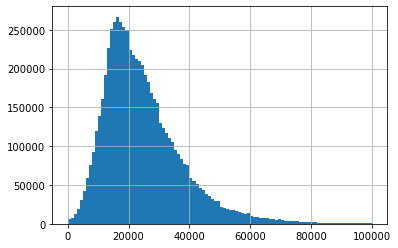

In [69]:
# plot distribution of mvr_price
df["mvr_price"].hist(bins=100)

Based on manual inspection, records with `mvr_price` under $X become highly error-prone. Extensive data validation is beyond the scope of this project, and these records will be dumped.

In [74]:
sum(df["mvr_price"] < 1000)

4264

In [75]:
df.loc[df["mvr_price"] < 1000,["price","mvr_price","mvr_salvage","make","mvr_make","mvr_purchase_date","status_date","mvr_model_year","miles","mvr_mileage"]].sort_values(by="mvr_price", ascending=True).sample(100)

,price,mvr_price,mvr_salvage,make,mvr_make,mvr_purchase_date,status_date,mvr_model_year,miles,mvr_mileage
9811897,6900.00,100.00,No,Ford,FORD,2022-01-20,2021-04-23 03:30:32,2005,84863.00,86500.00
12401470,1995.00,200.00,No,Hyundai,HYUNDAI,2019-08-02,2018-12-10 16:42:42,2009,119011.00,123470.00
12896972,35750.00,575.00,No,Chevrolet,CHEVROLET,2018-01-31,2018-02-01 16:59:33,2004,NaN,104492.00
7089990,NaN,350.00,No,Buick,BUIC,2019-02-08,2018-03-03 09:52:32,2013,124869.00,136426.00
11228431,3899.00,500.00,No,Jeep,JEEP,2019-09-10,2019-07-16 01:19:43,2004,140382.00,143423.00
1704813,NaN,200.00,Unknown,Ford,FORD,2022-08-08,2021-12-18 06:00:03,2013,132866.00,140086.00
10517827,NaN,500.00,No,Toyota,TOYOTA MOTOR CO,2022-06-13,2022-04-28 23:22:12,2007,146041.00,146200.00
9607332,NaN,500.00,No,Chevrolet,CHEVROLET,2022-10-18,2021-11-08 09:29:08,2011,116900.00,116958.00
3793787,NaN,651.96,No,Ford,FORD,2020-05-15,2020-01-17 21:14:26,2013,53001.00,53001.00
8129094,9995.00,800.00,No,Chrysler,CHRY,2022-05-03,2022-04-26 11:36:09,2015,68559.00,84347.00


In [ ]:
# plot distribution of mvr_price
#df["mvr_price"].hist(bins=100)

### Investigate Price Distribution for Relevant Subtypes

In [77]:
import matplotlib.pyplot as plt

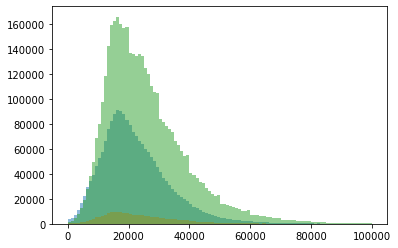

In [79]:
# by state
grouped = df.groupby('mvr_state')
for name, group in grouped:
    plt.hist(group['mvr_price'], bins=100, alpha=0.5, label=name)
plt.show()

## Subset Columns

In [89]:
df.columns

Index(['vin', 'price', 'miles', 'year', 'make', 'model', 'trim',
       'vehicle_type', 'body_type', 'body_subtype', 'drivetrain', 'fuel_type',
       'engine_block', 'engine_size', 'transmission', 'doors', 'cylinders',
       'city_mpg', 'highway_mpg', 'base_exterior_color', 'base_interior_color',
       'is_certified', 'is_transfer', 'scraped_at', 'status_date',
       'first_scraped_at', 'city', 'zip', 'latitude', 'longitude',
       'dealer_type', 'currency_indicator', 'miles_indicator',
       'photo_links_count', 'hvf_standard', 'hvf_optional',
       'mvr_purchase_date', 'mvr_price', 'mvr_make', 'mvr_mileage',
       'mvr_model_year', 'mvr_odometer_brand', 'mvr_salvage', 'mvr_state',
       'age_months', 'make_model_encode', 'make_model_trim_encode'],
      dtype='object')

In [92]:
df = df[['mvr_price',
       'make', 'model', 'trim', 'mvr_model_year','mvr_mileage','age_months',
       'vehicle_type', 'body_type', 'body_subtype', 'drivetrain', 'fuel_type',
       'engine_block', 'engine_size', 'transmission', 'doors', 'cylinders',
       'city_mpg', 'highway_mpg',
       'base_exterior_color', 'base_interior_color',
       'is_certified',  
       'zip','mvr_state',
       'hvf_standard', 'hvf_optional',
       'mvr_purchase_date',
        'make_model_encode', 'make_model_trim_encode']]